# Weather relation to cities coordinates

## Dependecies and configuration

In [7]:
# Import libraries.
import pandas as pd
import matplotlib.pyplot as plt
import os
import requests

from scipy import stats
from datetime import date

# Import keys.
from api_keys import weather_api_key
from api_keys import g_key

# Dataset location.
cities_json_file_path = os.path.join('Resources', 'city.list.json')

# Output file for 1000 unique cities (is good sample out of 200K cities)
one_thousand_unique_cities_path = os.path.join('output', 'one_thousand_unique_cities.csv')

# Weather API configuration
weather_api_url = "http://api.openweathermap.org/data/2.5/weather?"
units = "imperial"

# Base query URL
base_weather_data_for_a_city_url = f"{weather_api_url}appid={weather_api_key}&units={units}"


### Functions

In [21]:
# Get middle point
def get_middle_point(a_series):
    middle = ((a_series.max() + a_series.min() ) / 2)
    return middle

# Print scatter plot and save the plot as an image
def print_scatter_plot_with_regression_equation(x_series, y_series, marker, title, y_label, x_label, file_name, regress_values = None, line_eq = None):
    
    # Build scatter plot
    plt.scatter(x_series, y_series, marker = marker)
    
    if regress_values is not None:
        # Build line equation and annotate it to the scatter plot
        plt.plot(x_series, regress_values, "r-")
        plt.annotate(line_eq, (get_middle_point(x_series), get_middle_point(y_series)), fontsize = 15, color = "red")
    
    # Incorporate the other graph properties
    plt.title(f"{title} - {date.today()}")
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.grid(True)
    
    # Save the figure
    plt.savefig(f"output/{file_name}-{date.today()}.png")
    
    # Show plot
    plt.show()

# Perform linear regression. Return regressed values, the linear equation and the r-value
def linear_regression_with_equation(x_values, y_values):
    (slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_values, y_values)
    
    # Get regression values
    regress_values = x_values * slope + intercept
    
    # Create line equation string
    line_equation = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))
    
    # Print r square value
    print(f"The r-squared is: {rvalue**2}")
    
    return regress_values, line_equation

## Load dataset of cities and prepare sample dataframe

In [3]:
# Read cities dataset.
cities_df = pd.read_json(cities_json_file_path)

cities_coordinates = pd.json_normalize(cities_df['coord'])

cities_df = cities_df.merge(cities_coordinates, left_index = True, right_index = True) 
cities_df.drop(columns = ['coord'], inplace = True)

total_cities_count = cities_df['id'].unique()
print(f'Number of cities loaded: {len(total_cities_count)}')

Number of cities loaded: 209579


### Preparing sample of cities dataframe

In [4]:
# Divide cities in four groups.
# Each group will be made using the main imaginary lines dividing the Earth (the Prime meridian and the Equator).

# Cities in the first quadrant (longitude is negative and latitude is positive)
first_quadrant_cities = (cities_df['lon'] < 0) & (cities_df['lat'] > 0)
first_quadrant_cities_df = cities_df.loc[first_quadrant_cities]

# Cities in the second quadrant (both longitude and latitude are positive)
second_quadrant_cities = (cities_df['lon'] > 0) & (cities_df['lat'] > 0)
second_quadrant_cities_df = cities_df.loc[second_quadrant_cities]

# Cities in the third quadrant (both longitude and latitude are negative)
third_quadrant_cities = (cities_df['lon'] < 0) & (cities_df['lat'] < 0)
third_quadrant_cities_df = cities_df.loc[third_quadrant_cities]

# Cities in the fourth quadrant (longitude is positive and latitude is negative)
fourth_quadrant_cities = (cities_df['lon'] > 0) & (cities_df['lat'] < 0)
fourth_quadrant_cities_df = cities_df.loc[fourth_quadrant_cities]

# Get 1000 random unique cities in the world
temp_df = first_quadrant_cities_df.sample(n = 250)
one_thousand_cities = pd.DataFrame(temp_df)

temp_df = second_quadrant_cities_df.sample(n = 250)
one_thousand_cities = one_thousand_cities.append(temp_df)

temp_df = third_quadrant_cities_df.sample(n = 250)
one_thousand_cities = one_thousand_cities.append(temp_df)

temp_df = fourth_quadrant_cities_df.sample(n = 250)
one_thousand_cities = one_thousand_cities.append(temp_df)

one_thousand_cities.reset_index(inplace = True)
one_thousand_cities = one_thousand_cities.drop(columns = ['index'])
one_thousand_cities.rename(columns={'id': 'city_id'}, inplace = True)
one_thousand_cities.rename(columns={'name': 'city_name'}, inplace = True)
one_thousand_cities = one_thousand_cities[['city_id', 'city_name', 'state', 'country', 'lat', 'lon']]

sample_cities_count = one_thousand_cities['city_id'].unique()
print(f'Number of sample cities: {len(sample_cities_count)}')

one_thousand_cities.head()

Number of sample cities: 1000


,city_id,city_name,state,country,lat,lon
0,3598804,Chajul,,GT,15.485280,-91.034172
1,6172733,Upsala,,CA,49.050121,-90.466881
2,3972702,General Enrique Estrada,,MX,23.000000,-102.741669
3,5901684,Birchy Bay,,CA,49.349930,-54.731430
4,2641922,Mytholmroyd,,GB,53.730652,-1.982580


## Start calculations and building plots

In [5]:
# Get weather data for all 1000 unique cities

counter = 0

print("Start data request...")

# Loop through the list of cities and perform a request for data on each
for index, city in one_thousand_cities.iterrows():
    id_param = f"&id={city['city_id']}"
    counter += 1
    
    print(f"{counter} - Getting weather data for: {city['city_id']} - {city['city_name']}, {city['country']} ... ")
    try:
        response = requests.get(base_weather_data_for_a_city_url + id_param).json()
        print(f"Data received.")
        
        one_thousand_cities.loc[index, 'temperature'] = response['main']['temp']
        one_thousand_cities.loc[index, 'humidity'] = response['main']['humidity']
        one_thousand_cities.loc[index, 'cloudiness'] = response['clouds']['all']
        one_thousand_cities.loc[index, 'wind_speed'] = response['wind']['speed']
        one_thousand_cities.loc[index, 'weather_condition'] = response['weather'][0]['main']
        one_thousand_cities.loc[index, 'weather_condition_desc'] = response['weather'][0]['description']
    except:
        print(f"There was an error retrieving this city weather data: {city['city_id']} - {city['city_name']}, {city['country']}")

print("Data request completed.")

one_thousand_cities.dropna(subset = ['temperature'], inplace = True)

one_thousand_cities.info()


Start data request...
1 - Getting weather data for: 3598804 - Chajul, GT ... 
Data received.
2 - Getting weather data for: 6172733 - Upsala, CA ... 
Data received.
3 - Getting weather data for: 3972702 - General Enrique Estrada, MX ... 
Data received.
4 - Getting weather data for: 5901684 - Birchy Bay, CA ... 
Data received.
5 - Getting weather data for: 2641922 - Mytholmroyd, GB ... 
Data received.
6 - Getting weather data for: 8013702 - Valpaços, PT ... 
Data received.
7 - Getting weather data for: 6139445 - Salmon Cove, CA ... 
Data received.
8 - Getting weather data for: 4351037 - Charlestown, US ... 
Data received.
9 - Getting weather data for: 6614794 - Cazalis, FR ... 
Data received.
10 - Getting weather data for: 4135349 - Warren, US ... 
Data received.
11 - Getting weather data for: 6617270 - Vieux-Pont, FR ... 
Data received.
12 - Getting weather data for: 4099679 - Arkansas County, US ... 
Data received.
13 - Getting weather data for: 3315332 - Hartstown, IE ... 
Data receiv

Data received.
109 - Getting weather data for: 6098354 - Parham, CA ... 
Data received.
110 - Getting weather data for: 6448392 - Ayguemorte-les-Graves, FR ... 
Data received.
111 - Getting weather data for: 5173962 - Tiltonsville, US ... 
Data received.
112 - Getting weather data for: 2265169 - Parede, PT ... 
Data received.
113 - Getting weather data for: 4005370 - Guadalupe y Calvo, MX ... 
Data received.
114 - Getting weather data for: 4921083 - Hamilton, US ... 
Data received.
115 - Getting weather data for: 3612813 - Dulce Nombre, HN ... 
Data received.
116 - Getting weather data for: 4125388 - Paragould, US ... 
Data received.
117 - Getting weather data for: 2635281 - Tyldesley, GB ... 
Data received.
118 - Getting weather data for: 4013052 - Concepción, MX ... 
Data received.
119 - Getting weather data for: 6435543 - Quettehou, FR ... 
Data received.
120 - Getting weather data for: 5908443 - Brent, CA ... 
Data received.
121 - Getting weather data for: 5203164 - New Cumberland,

Data received.
215 - Getting weather data for: 2739841 - Estação do Mogadouro, PT ... 
Data received.
216 - Getting weather data for: 2571059 - Tizgane, MA ... 
Data received.
217 - Getting weather data for: 4158604 - Highland City, US ... 
Data received.
218 - Getting weather data for: 3109966 - Santa Comba, ES ... 
Data received.
219 - Getting weather data for: 2266777 - Malveira, PT ... 
Data received.
220 - Getting weather data for: 3985846 - San Juan de Sabinas, MX ... 
Data received.
221 - Getting weather data for: 2740013 - Enxames, PT ... 
Data received.
222 - Getting weather data for: 6361226 - Valtajeros, ES ... 
Data received.
223 - Getting weather data for: 6357808 - Adobes, ES ... 
Data received.
224 - Getting weather data for: 3682393 - Florida, CO ... 
Data received.
225 - Getting weather data for: 3023557 - Coron, FR ... 
Data received.
226 - Getting weather data for: 2412778 - Kuntaur, GM ... 
Data received.
227 - Getting weather data for: 5335256 - Cedar Ridge, US ...

Data received.
322 - Getting weather data for: 6617458 - Solaize, FR ... 
Data received.
323 - Getting weather data for: 2795056 - Ingelmunster, BE ... 
Data received.
324 - Getting weather data for: 2828206 - Steinenbronn, DE ... 
Data received.
325 - Getting weather data for: 2888033 - Kleinweichs, DE ... 
Data received.
326 - Getting weather data for: 6445047 - Verdun-sur-Garonne, FR ... 
Data received.
327 - Getting weather data for: 7872404 - Heiligenkreuz am Waasen, AT ... 
Data received.
328 - Getting weather data for: 2925720 - Forstmehren, DE ... 
Data received.
329 - Getting weather data for: 3176055 - Giuliano di Roma, IT ... 
Data received.
330 - Getting weather data for: 680560 - Costeştii din Vale, RO ... 
Data received.
331 - Getting weather data for: 1804208 - Leiyang, CN ... 
Data received.
332 - Getting weather data for: 2937201 - Diestelow, DE ... 
Data received.
333 - Getting weather data for: 2338334 - Ikang, NG ... 
Data received.
334 - Getting weather data for: 1

Data received.
430 - Getting weather data for: 2325314 - Owo, NG ... 
Data received.
431 - Getting weather data for: 3163844 - Zovencedo, IT ... 
Data received.
432 - Getting weather data for: 6542339 - Casavatore, IT ... 
Data received.
433 - Getting weather data for: 3100881 - Dąbie, PL ... 
Data received.
434 - Getting weather data for: 2659298 - Ollon, CH ... 
Data received.
435 - Getting weather data for: 2473358 - Enfidha, TN ... 
Data received.
436 - Getting weather data for: 3208432 - Isterberg, DE ... 
Data received.
437 - Getting weather data for: 7643657 - Liaonan, CN ... 
Data received.
438 - Getting weather data for: 3014289 - Guignicourt, FR ... 
Data received.
439 - Getting weather data for: 3166521 - Silvano Pietra, IT ... 
Data received.
440 - Getting weather data for: 2729907 - Longyearbyen, SJ ... 
Data received.
441 - Getting weather data for: 3103751 - Bęczarka, PL ... 
Data received.
442 - Getting weather data for: 1723481 - Buenavista, PH ... 
Data received.
443 

Data received.
538 - Getting weather data for: 3694720 - Mochumí, PE ... 
Data received.
539 - Getting weather data for: 3847599 - Las Vertientes, AR ... 
Data received.
540 - Getting weather data for: 3446138 - Três Corações, BR ... 
Data received.
541 - Getting weather data for: 3433822 - General Almada, AR ... 
Data received.
542 - Getting weather data for: 3450024 - Santana, BR ... 
Data received.
543 - Getting weather data for: 3904890 - Santa Elena, BO ... 
Data received.
544 - Getting weather data for: 3439619 - Vichadero, UY ... 
Data received.
545 - Getting weather data for: 3393764 - Oeiras, BR ... 
Data received.
546 - Getting weather data for: 3397277 - João Pessoa, BR ... 
Data received.
547 - Getting weather data for: 3665474 - Acre, BR ... 
Data received.
548 - Getting weather data for: 3834647 - Tapalqué, AR ... 
Data received.
549 - Getting weather data for: 3442057 - Las Piedras, UY ... 
Data received.
550 - Getting weather data for: 3654825 - La Victoria, EC ... 
Dat

Data received.
646 - Getting weather data for: 3836194 - Santa Lucía, AR ... 
Data received.
647 - Getting weather data for: 3428533 - Partido de San Pedro, AR ... 
Data received.
648 - Getting weather data for: 3459855 - Joanópolis, BR ... 
Data received.
649 - Getting weather data for: 3445162 - Vespasiano, BR ... 
Data received.
650 - Getting weather data for: 3455251 - Panorama, BR ... 
Data received.
651 - Getting weather data for: 6254880 - Villa Pacajes, BO ... 
Data received.
652 - Getting weather data for: 3456309 - Nhandeara, BR ... 
Data received.
653 - Getting weather data for: 3458701 - Lavínia, BR ... 
Data received.
654 - Getting weather data for: 3449856 - Santa Rita do Araguaia, BR ... 
Data received.
655 - Getting weather data for: 3894426 - Coyhaique, CL ... 
Data received.
656 - Getting weather data for: 3460358 - Jaci, BR ... 
Data received.
657 - Getting weather data for: 3834826 - Tacuarí, AR ... 
Data received.
658 - Getting weather data for: 3880306 - Región de

Data received.
753 - Getting weather data for: 8068208 - Balong Kulon, ID ... 
Data received.
754 - Getting weather data for: 8045983 - Desa Saguling, ID ... 
Data received.
755 - Getting weather data for: 2148435 - Staughton Vale, AU ... 
Data received.
756 - Getting weather data for: 2099101 - Boroko, PG ... 
Data received.
757 - Getting weather data for: 1647005 - Cibingbin, ID ... 
Data received.
758 - Getting weather data for: 7406800 - Klau, ID ... 
Data received.
759 - Getting weather data for: 1106407 - Avenues, ZW ... 
Data received.
760 - Getting weather data for: 1632334 - Pariaman, ID ... 
Data received.
761 - Getting weather data for: 2169535 - Dalby, AU ... 
Data received.
762 - Getting weather data for: 8054206 - Citapen, ID ... 
Data received.
763 - Getting weather data for: 984998 - Ladysmith, ZA ... 
Data received.
764 - Getting weather data for: 924567 - Nsanje District, MW ... 
Data received.
765 - Getting weather data for: 7089390 - Doma, ID ... 
Data received.
766

Data received.
862 - Getting weather data for: 8140981 - Mentaras, ID ... 
Data received.
863 - Getting weather data for: 2061418 - Smithfield, AU ... 
Data received.
864 - Getting weather data for: 7920634 - Bojongkalapa, ID ... 
Data received.
865 - Getting weather data for: 6385763 - Kaliduren, ID ... 
Data received.
866 - Getting weather data for: 7911929 - Paledang, ID ... 
Data received.
867 - Getting weather data for: 1646613 - Cikijing, ID ... 
Data received.
868 - Getting weather data for: 2169145 - Deer Park, AU ... 
Data received.
869 - Getting weather data for: 8024167 - Sukamaju, ID ... 
Data received.
870 - Getting weather data for: 153759 - Misungwi, TZ ... 
Data received.
871 - Getting weather data for: 8052637 - Binangun, ID ... 
Data received.
872 - Getting weather data for: 1627549 - Serang, ID ... 
Data received.
873 - Getting weather data for: 2070172 - Hamel, AU ... 
Data received.
874 - Getting weather data for: 7753740 - Gunungempuk, ID ... 
Data received.
875 -

Data received.
972 - Getting weather data for: 7783025 - Tajur, ID ... 
Data received.
973 - Getting weather data for: 2170528 - Coonawarra, AU ... 
Data received.
974 - Getting weather data for: 2160246 - Liffey, AU ... 
Data received.
975 - Getting weather data for: 2174360 - Box Hill, AU ... 
Data received.
976 - Getting weather data for: 8023864 - Sukasari, ID ... 
Data received.
977 - Getting weather data for: 1053384 - Toamasina, MG ... 
Data received.
978 - Getting weather data for: 8058273 - Pasucen, ID ... 
Data received.
979 - Getting weather data for: 928657 - Karonga District, MW ... 
Data received.
980 - Getting weather data for: 2156894 - Moriarty Road, AU ... 
Data received.
981 - Getting weather data for: 2184975 - Papamoa, NZ ... 
Data received.
982 - Getting weather data for: 2160882 - Kynuna, AU ... 
Data received.
983 - Getting weather data for: 2154795 - Nowa Nowa, AU ... 
Data received.
984 - Getting weather data for: 7035853 - Ngroto, ID ... 
Data received.
985 -

## Save data in CSV format

In [9]:
one_thousand_cities.to_csv(one_thousand_unique_cities_path, index = False, header = True)


## Create scatter plots

### Scatter plots

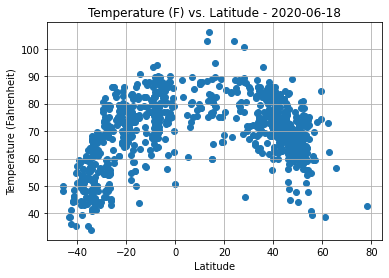

In [22]:
# Temperature (F) vs. Latitude

print_scatter_plot_with_regression_equation(
    one_thousand_cities["lat"],
    one_thousand_cities["temperature"],
    "o",
    "Temperature (F) vs. Latitude",
    "Temperature (Fahrenheit)",
    "Latitude",
    "TemperatureVSLatitude"
)

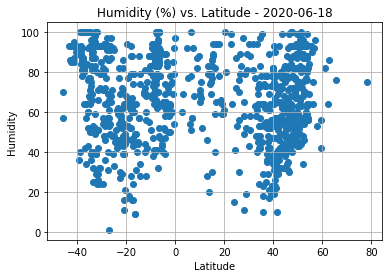

In [23]:
# Humidity (%) vs. Latitude

print_scatter_plot_with_regression_equation(
    one_thousand_cities["lat"],
    one_thousand_cities["humidity"],
    "o",
    "Humidity (%) vs. Latitude",
    "Humidity",
    "Latitude",
    "HumidityVSLatitude"
)

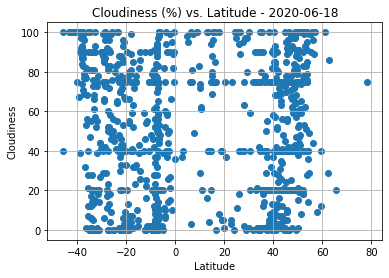

In [24]:
# Cloudiness (%) vs. Latitude

print_scatter_plot_with_regression_equation(
    one_thousand_cities["lat"],
    one_thousand_cities["cloudiness"],
    "o",
    "Cloudiness (%) vs. Latitude",
    "Cloudiness",
    "Latitude",
    "CloudinessVSLatitude"
)

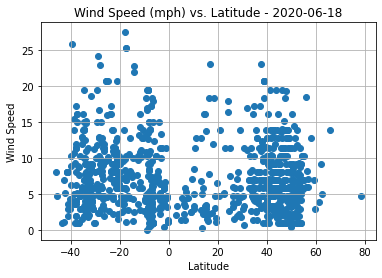

In [25]:
# Wind Speed (mph) vs. Latitude

print_scatter_plot_with_regression_equation(
    one_thousand_cities["lat"],
    one_thousand_cities["wind_speed"],
    "o",
    "Wind Speed (mph) vs. Latitude",
    "Wind Speed",
    "Latitude",
    "WindSpeedVSLatitude"
)

### Linear regression by Hemisphere

In [26]:
# Divide cities by hemispheres

northern_hemisphere_df = one_thousand_cities.loc[one_thousand_cities['lat'] > 0]
southern_hemisphere_df = one_thousand_cities.loc[one_thousand_cities['lat'] < 0]


The r-squared is: 0.2917214864498261


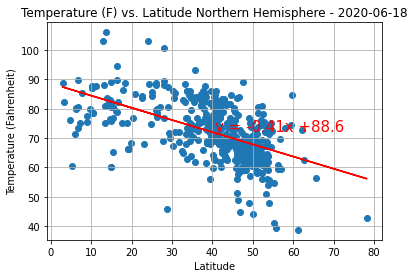

The r-squared is: 0.5101308913719405


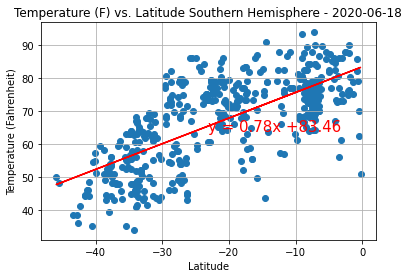

In [27]:
# Perform a linear regression on temperature vs. latitude for the northern hemisphere

(regress_values, line_eq) = linear_regression_with_equation(
    northern_hemisphere_df["lat"], 
    northern_hemisphere_df["temperature"]
)

# Scatter plot and Linear Equation
print_scatter_plot_with_regression_equation(
    northern_hemisphere_df["lat"],
    northern_hemisphere_df["temperature"],
    "o",
    "Temperature (F) vs. Latitude Northern Hemisphere",
    "Temperature (Fahrenheit)",
    "Latitude",
    "TemperatureVSLatitude-NH",
    regress_values,
    line_eq
)

# Perform a linear regression on temperature vs. latitude for the southern hemisphere

(regress_values, line_eq) = linear_regression_with_equation(
    southern_hemisphere_df["lat"],
    southern_hemisphere_df["temperature"]
)

# Scatter plot and Linear Equation
print_scatter_plot_with_regression_equation(
    southern_hemisphere_df["lat"],
    southern_hemisphere_df["temperature"],
    "o",
    "Temperature (F) vs. Latitude Southern Hemisphere",
    "Temperature (Fahrenheit)",
    "Latitude",
    "TemperatureVSLatitude-SH",
    regress_values,
    line_eq
)


The r-squared is: 0.001056391874694269


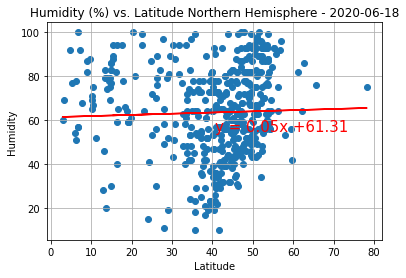

The r-squared is: 0.0013395434553716823


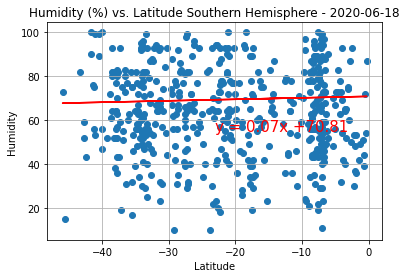

In [28]:
# Perform a linear regression on Humidity (%) vs. latitude for the northern hemisphere
(regress_values, line_eq) = linear_regression_with_equation(
    northern_hemisphere_df["lat"], 
    northern_hemisphere_df["humidity"]
)

# Scatter plot and Linear Equation
print_scatter_plot_with_regression_equation(
    northern_hemisphere_df["lat"],
    northern_hemisphere_df["humidity"],
    "o",
    "Humidity (%) vs. Latitude Northern Hemisphere",
    "Humidity",
    "Latitude",
    "HumidityVSLatitude-NH",
    regress_values,
    line_eq
)

# Perform a linear regression on Humidity (%) vs. latitude for the southern hemisphere
(regress_values, line_eq) = linear_regression_with_equation(
    southern_hemisphere_df["lat"],
    southern_hemisphere_df["humidity"]
)

# Scatter plot and Linear Equation
print_scatter_plot_with_regression_equation(
    southern_hemisphere_df["lat"],
    northern_hemisphere_df["humidity"],
    "o",
    "Humidity (%) vs. Latitude Southern Hemisphere",
    "Humidity",
    "Latitude",
    "HumidityVSLatitude-SH",
    regress_values,
    line_eq
)

The r-squared is: 0.0024792925140115327


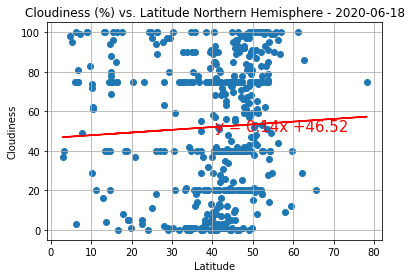

The r-squared is: 0.02917569716101803


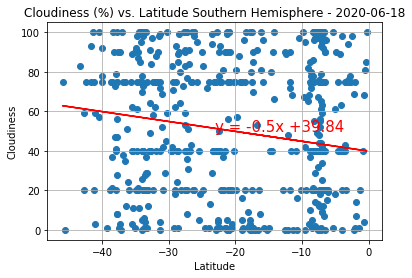

In [29]:
# Perform a linear regression on Cloudiness (%) vs. latitude for the northern hemisphere
(regress_values, line_eq) = linear_regression_with_equation(
    northern_hemisphere_df["lat"], 
    northern_hemisphere_df["cloudiness"]
)

# Scatter plot and Linear Equation
print_scatter_plot_with_regression_equation(
    northern_hemisphere_df["lat"],
    northern_hemisphere_df["cloudiness"],
    "o",
    "Cloudiness (%) vs. Latitude Northern Hemisphere",
    "Cloudiness",
    "Latitude",
    "CloudinessVSLatitude-NH",
    regress_values,
    line_eq
)

# Perform a linear regression on Cloudiness (%) vs. latitude for the southern hemisphere
(regress_values, line_eq) = linear_regression_with_equation(
    southern_hemisphere_df["lat"],
    southern_hemisphere_df["cloudiness"]
)

# Scatter plot and Linear Equation
print_scatter_plot_with_regression_equation(
    southern_hemisphere_df["lat"],
    northern_hemisphere_df["cloudiness"],
    "o",
    "Cloudiness (%) vs. Latitude Southern Hemisphere",
    "Cloudiness",
    "Latitude",
    "CloudinessVSLatitude-SH",
    regress_values,
    line_eq
)

The r-squared is: 0.004643838665614504


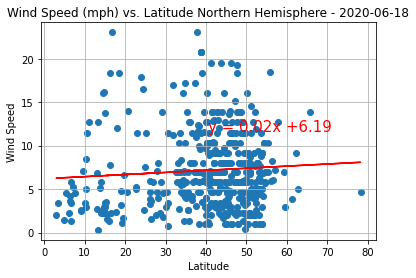

The r-squared is: 0.009123307827700012


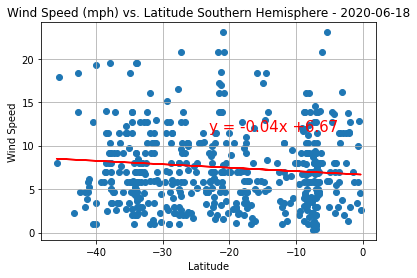

In [30]:
# Perform a linear regression on Wind Speed (mph) vs. latitude for the northern hemisphere
(regress_values, line_eq) = linear_regression_with_equation(
    northern_hemisphere_df["lat"], 
    northern_hemisphere_df["wind_speed"]
)

# Scatter plot and Linear Equation
print_scatter_plot_with_regression_equation(
    northern_hemisphere_df["lat"],
    northern_hemisphere_df["wind_speed"],
    "o",
    "Wind Speed (mph) vs. Latitude Northern Hemisphere",
    "Wind Speed",
    "Latitude",
    "WindSpeedVSLatitude-NH",
    regress_values,
    line_eq
)

# Perform a linear regression on Wind Speed (%) vs. latitude for the southern hemisphere
(regress_values, line_eq) = linear_regression_with_equation(
    southern_hemisphere_df["lat"],
    southern_hemisphere_df["wind_speed"]
)

# Scatter plot and Linear Equation
print_scatter_plot_with_regression_equation(
    southern_hemisphere_df["lat"],
    northern_hemisphere_df["wind_speed"],
    "o",
    "Wind Speed (mph) vs. Latitude Southern Hemisphere",
    "Wind Speed",
    "Latitude",
    "WindSpeedVSLatitude-SH",
    regress_values,
    line_eq
)